In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import yaml

from gammapy.datasets import MapDataset, Datasets, FluxPointsDataset
from gammapy.maps import Map
from gammapy.makers import FoVBackgroundMaker
from gammapy.catalog import SourceCatalogHGPS, SourceCatalogGammaCat, SourceCatalog4FGL 

In [2]:
hessera='hess1'
muoneff_flag= True
edisp = True

if hessera =='hess1u':
    muoneff_flag=False

name = f'20220702_{hessera}_muoneff{muoneff_flag}_edisp{edisp}.fits'

In [3]:
hess= MapDataset.read(name)
hess.mask_safe = Map.from_geom(geom=hess.counts.geom, data=np.ones_like(hess.counts.data).astype(bool))   
hess.mask_safe &= hess.counts.geom.region_mask(f"galactic;circle(0, 0, 3)")

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

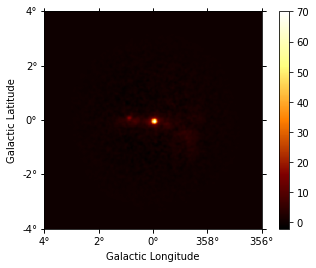

In [4]:
(hess.counts-hess.background).sum_over_axes().smooth(2).plot(add_cbar=True)

In [5]:
HGPS, FGL4 = SourceCatalogHGPS(), SourceCatalog4FGL() 

In [6]:
catalog = HGPS
mask1 = np.abs(catalog.table['GLAT']) < 2.6
mask2 = (catalog.table['GLON'] < 2.6) + (catalog.table['GLON'] > 357.4)
mask = mask1 & mask2

HGPS_models = catalog[mask].to_models()

In [7]:
from gammapy.modeling.models import SkyModel, TemplateSpatialModel, PowerLawNormSpectralModel

diff_map = Map.read('/home/saturn/caph/mppi043h/diffusiontemplate/cont_pcut_v3.fits')
#diff_map.geom.axes['energy'].name = 'energy_true'

diff= SkyModel(spectral_model=PowerLawNormSpectralModel(),
               spatial_model=TemplateSpatialModel(diff_map, normalize=False),
               name='diff-emission')

In [8]:
initial_model_hess = HGPS_models
hess.models = initial_model_hess.copy()
hess.models += diff
hess = FoVBackgroundMaker().make_default_fov_background_model(dataset=hess)

In [9]:
dataset = hess
dataset.mask_fit = Map.from_geom(geom=dataset.counts.geom, data=np.ones_like(dataset.counts.data).astype(bool))   
dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"galactic;circle(358.71, -0.64, 0.7)")

if hessera == 'hess1':
    dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"galactic;circle(359.5, -0.2, 0.2)")
    dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"galactic;circle(358.45, 0.15, 0.35)")

In [14]:
frozen_sources= ['HESS J1745-303', 'HESS J1746-308']

for s in hess.models:
    if s.name in frozen_sources:
        s.parameters.freeze_all()
        
frozen_pos_sources= ['HESS J1741-302', 'HESS J1746-285']
for s in hess.models:
    if s.name in frozen_pos_sources:
        s.spatial_model.parameters.freeze_all()
        
hess.models['diff-emission'].parameters['tilt'].frozen=False
hess.models[-1].parameters['tilt'].frozen=False

In [15]:
print(hess.models)

DatasetModels

Component 0: SkyModel

  Name                      : HESS J1741-302
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      2.300   +/-    0.20             
    amplitude               :   2.10e-13   +/- 4.0e-14 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    lon_0        (frozen)   :    358.277       deg         
    lat_0        (frozen)   :      0.049       deg         

Component 1: SkyModel

  Name                      : HESS J1745-290
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      2.140   +/-    0.02             
    amplitude               :   2.55e-12   +/- 4.0e-14 1 / (cm2 s TeV)
    reference    (fro

In [16]:
from gammapy.modeling import Fit

result0= Fit().run(datasets=[hess])
print(result0)

Position <SkyCoord (Galactic): (l, b) in deg
    (46.9836965, -0.04391105)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (46.9836965, -0.04391105)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (312.90607401, -0.04391105)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (312.90607401, -0.04391105)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (4.64876638, -0.04391105)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (4.64876638, -0.04391105)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (355.24100413, -0.04391105)> is outside valid IRF map range, using nearest IRF defined within
Positio

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 2654
	total stat : 926228.75

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 2654
	total stat : 926228.75




/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/maps/wcs/ndmap.py:372: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow(data, **kwargs)


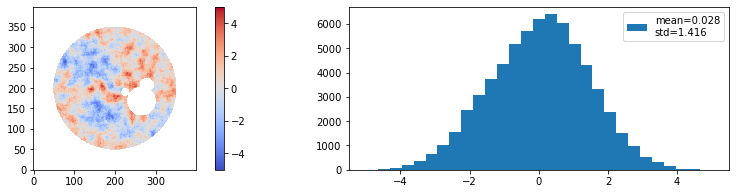

In [17]:
from gammapy.estimators import ExcessMapEstimator

estimator = ExcessMapEstimator(
    correlation_radius="0.2 deg",
    selection_optional=[],
    energy_edges=[0.1, 100] * u.TeV,
)
result = estimator.run(hess)

fig, ax = plt.subplots(1,2, figsize=(15, 3))
result["sqrt_ts"].plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ax=ax[0]);
data=result["sqrt_ts"].data.ravel()
ax[1].hist(data, bins=np.linspace(-5,5,30), label=f'mean={np.nanmean(data):.3f}\nstd={np.nanstd(data):.3f}');
plt.legend()

/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


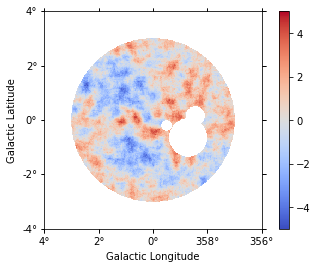

In [18]:
(result["sqrt_ts"]).plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5);

/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


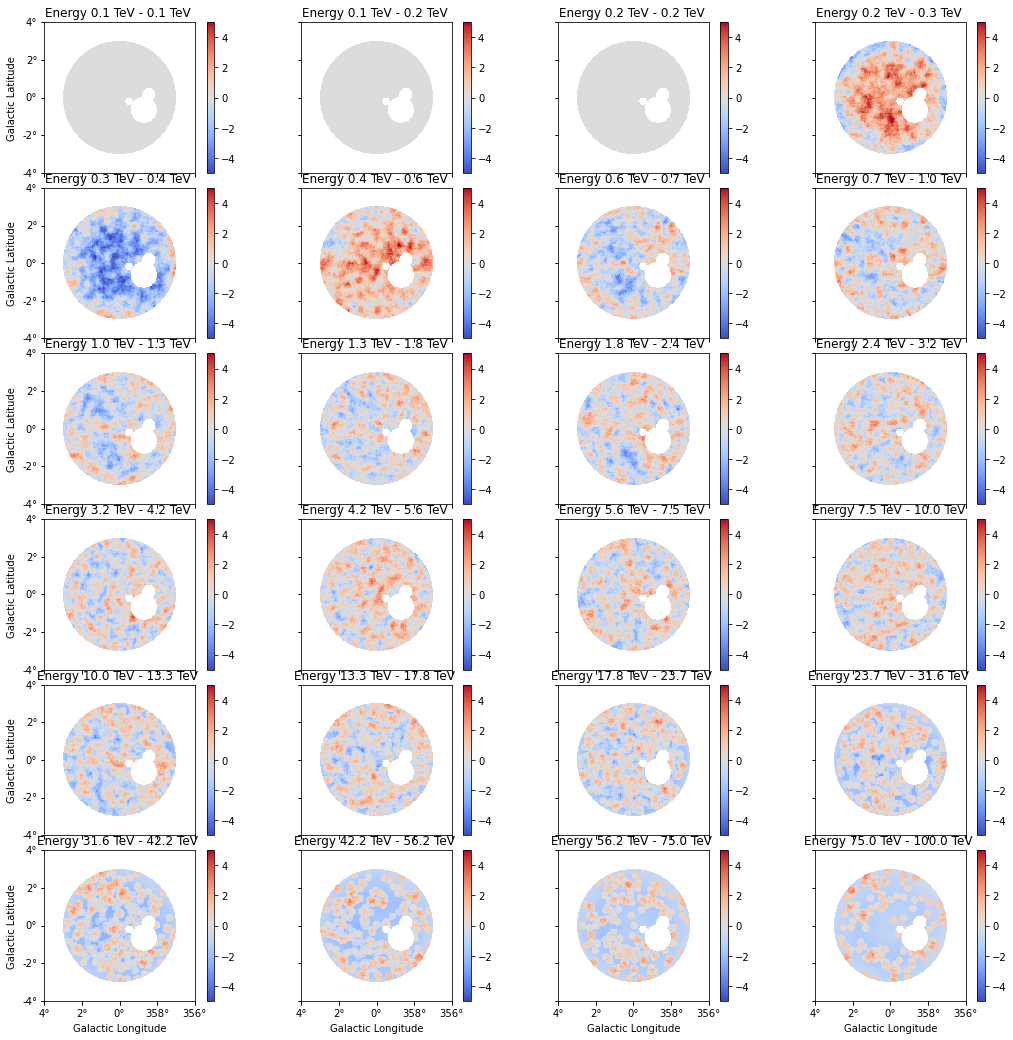

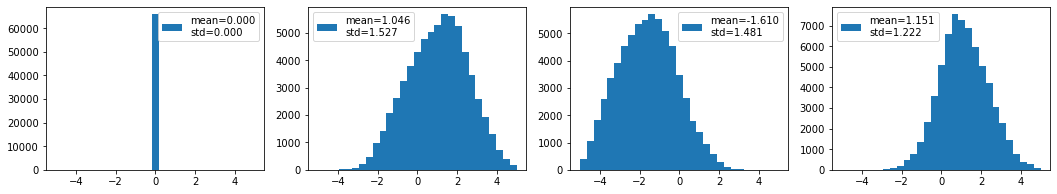

In [19]:
from gammapy.estimators import ExcessMapEstimator

estimator = ExcessMapEstimator(
    correlation_radius="0.2 deg",
    selection_optional=[],
    energy_edges=dataset.counts.geom.axes['energy'].edges,
)
result = estimator.run(hess)

result["sqrt_ts"].plot_grid(
    figsize=(18, 18), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=4);

fig, ax = plt.subplots(1,4, figsize=(18, 3))

for i in range(2, 6):
    data=result["sqrt_ts"].data[i].ravel()
    ax[i-2].hist(data, bins=np.linspace(-5,5,30), label=f'mean={np.nanmean(data):.3f}\nstd={np.nanstd(data):.3f}');
    ax[i-2].legend()

In [20]:
from gammapy.estimators import FluxPoints, FluxPointsEstimator

fp_central = FluxPointsEstimator(
    energy_edges=hess.counts.geom.axes['energy'].edges,
    source="HESS J1745-290",
).run([hess])

Position <SkyCoord (Galactic): (l, b) in deg
    (358.27682495, 0.04908089)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (359.94484088, -0.04454572)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (358.64483643, -0.56421703)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (0.14, -0.114)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (358.44821167, -1.11440229)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (0.86687907, 0.07410108)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, 

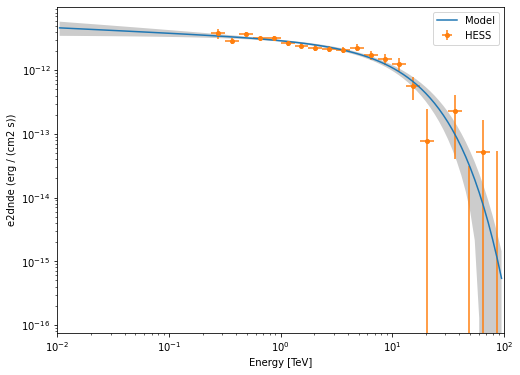

In [21]:
x_axis = hess.counts.geom.axes['energy'].center.value
energy_bounds = [0.01, 100] * u.TeV
sed_type = "e2dnde"

for s, fp in zip(['HESS J1745-290'], [fp_central]):
    plt.figure(figsize=(8, 6))

    ax = hess.models[s].spectral_model.plot(
        energy_bounds=energy_bounds, sed_type=sed_type, label="Model")
    hess.models[s].spectral_model.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type)
    fp.plot(ax=ax, sed_type=sed_type, label="HESS")
    ax.set_xlim(energy_bounds)
    plt.legend();

    plt.show()

In [22]:
name = 'fp_'+f'20220702_{hessera}_muoneff{muoneff_flag}_edisp{edisp}.fits'
#fp_central.write(name)

In [23]:
fp_edges = np.concatenate((hess.counts.geom.axes['energy'].edges[:17], [20, 80]*u.TeV))

In [24]:
fp_edges 

<Quantity [ 0.1       ,  0.13335214,  0.17782794,  0.23713737,  0.31622777,
            0.4216965 ,  0.56234133,  0.74989421,  1.        ,  1.33352143,
            1.77827941,  2.37137371,  3.16227766,  4.21696503,  5.62341325,
            7.49894209, 10.        , 20.        , 80.        ] TeV>

In [25]:
fp_central = FluxPointsEstimator(
    energy_edges=fp_edges,
    source="HESS J1745-290",
).run([hess])

Position <SkyCoord (Galactic): (l, b) in deg
    (358.27682495, 0.04908089)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (359.94484088, -0.04454572)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (358.64483643, -0.56421703)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (0.14, -0.114)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (358.44821167, -1.11440229)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (0.86687907, 0.07410108)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, 

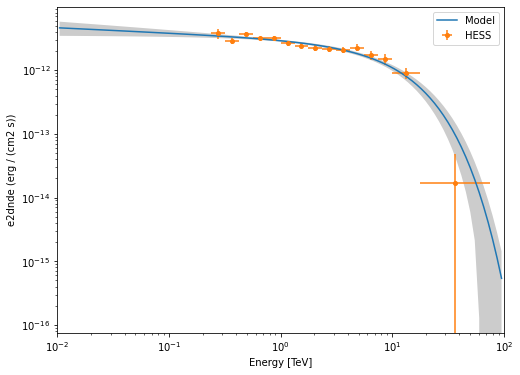

In [26]:
x_axis = hess.counts.geom.axes['energy'].center.value
energy_bounds = [0.01, 100] * u.TeV
sed_type = "e2dnde"

for s, fp in zip(['HESS J1745-290'], [fp_central]):
    plt.figure(figsize=(8, 6))

    ax = hess.models[s].spectral_model.plot(
        energy_bounds=energy_bounds, sed_type=sed_type, label="Model")
    hess.models[s].spectral_model.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type)
    fp.plot(ax=ax, sed_type=sed_type, label="HESS")
    ax.set_xlim(energy_bounds)
    plt.legend();

    plt.show()

In [27]:
fp_central.to_table()

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,ts,sqrt_ts,npred [1],npred_excess [1],stat,is_ul,counts [1],success
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,bool,float64,bool
0.11547819846894583,0.10000000000000002,0.1333521432163324,1.7567630064836515e-10,5.862930265309164e-12,6.742747771632616e-13,nan,nan,0.0,-0.0,0.0,0.0,1.3157799999976809e-20,True,0.0,False
0.1539926526059492,0.1333521432163324,0.1778279410038923,9.612401389113094e-11,4.277986398506528e-12,6.560720956431936e-13,nan,nan,0.0,-0.0,0.0,0.0,1.3157799999976809e-20,True,0.0,False
0.20535250264571459,0.1778279410038923,0.23713737056616552,5.253707928727895e-11,3.1180380788204714e-12,6.376468557930385e-13,nan,nan,0.0,-0.0,0.0,0.0,1.3157799999976809e-20,True,0.0,False
0.27384196342643613,0.23713737056616552,0.316227766016838,2.8671710668097445e-11,2.2692369094742157e-12,6.188150006052557e-13,1.1041753393454263,0.20842198921476496,34.772938516020076,5.896858359840439,45711.893155965394,142.1631,77822.98705773955,False,50312.0,True
0.36517412725483767,0.316227766016838,0.4216965034285822,1.561634401070755e-11,1.6482386442231898e-12,5.993456158894166e-13,0.8570047325948208,0.08846743018488513,124.46563200598757,11.156416629276068,95292.80810559448,365.39404,53383.632616238625,False,87072.0,True
0.48696752516586306,0.4216965034285822,0.5623413251903491,8.483122589544662e-12,1.1940323259602592e-12,5.789507922950778e-13,1.1458560269955844,0.08229556711653864,297.1424690431013,17.237820890214092,79527.00021084597,544.6569,66542.2921354271,False,84748.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.7384196342643614,2.371373705661655,3.1622776601683795,1.9100032292624263e-13,1.5132723854824442e-13,4.120575325950249e-13,0.9335344077963613,0.09910731177876568,178.59302424866473,13.3638701074451,16259.707730475046,182.82266,70012.10524087568,False,16461.0,True


In [28]:
name = 'fp_'+f'20220702_{hessera}_muoneff{muoneff_flag}_edisp{edisp}.fits'
fp_central.write(name, overwrite=True)